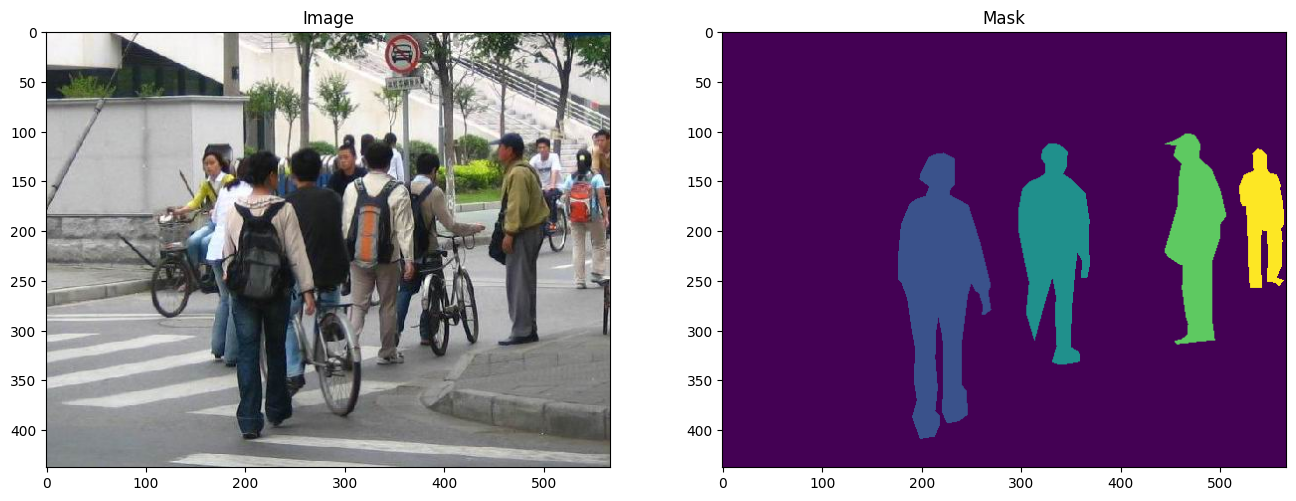

In [1]:
import matplotlib.pyplot as plt

from torchvision.io import read_image


image = read_image("datasets/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("datasets/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16,8))
# subplot 121 means 1 row, 2 columns, first plot
plt.subplot(121)
plt.title("Image")
# permute 1,2,0 means the order of the axis
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all images and their masks
        # sort them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx): 
        # load an image and its mask at idx
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        # Read image and mask
        image = read_image(img_path)
        mask = read_image(mask_path)
        # Each person is a different color. Get the unique colors
        obj_ids = torch.unique(mask)
        # First id is always background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # Split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # Get bounding boxes from masks
        boxes = masks_to_boxes(masks)

        # torch.ones creates a tensor of ones with the shape specified
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx

        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # wrap sample and targets into torch vision tv_sensors
        img = tv_tensors.Image(image)
        boxes = tv_tensors.BoundingBoxes(boxes, format="xyxy", canvas_size=F.get_size(img))

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="xyxy", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# Get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/hkppp/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:04<00:00, 35.2MB/s] 


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 3 different sizes and 2 aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=7,
    sampling_ratio=2,
)

# Put the pieces together inside a FasterRCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /home/hkppp/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 34.7MB/s]


In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

In [24]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2025-10-27 15:01:08--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’

     0K ...                                                   100%  123M=0s

2025-10-27 15:01:08 (123 MB/s) - ‘engine.py’ saved [4063/4063]

--2025-10-27 15:01:08--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Saving

0

In [8]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [11]:
import utils_pt as utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset("datasets/PennFudanPed", get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets) # returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions[0])


{'loss_classifier': tensor(0.0546, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0297, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0110, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0024, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [26]:
from engine import train_one_epoch, evaluate

device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available()
    else torch.device("cpu")
)

num_classes = 2

dataset = PennFudanDataset("datasets/PennFudanPed", get_transform(train=True))
dataset_test = PennFudanDataset("datasets/PennFudanPed", get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, collate_fn=utils.collate_fn
)

model = get_instance_segmentation_model(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/hkppp/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:08<00:00, 21.0MB/s] 
/home/hkppp/Classes/machinelearningpractice/principles_of_ml/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:01:26  lr: 0.000090  loss: 2.5584 (2.5584)  loss_classifier: 0.5524 (0.5524)  loss_box_reg: 0.3085 (0.3085)  loss_mask: 1.6245 (1.6245)  loss_objectness: 0.0584 (0.0584)  loss_rpn_box_reg: 0.0146 (0.0146)  time: 1.4445  data: 0.0439  max mem: 2598
Epoch: [0]  [10/60]  eta: 0:00:18  lr: 0.000936  loss: 1.4406 (1.5820)  loss_classifier: 0.4153 (0.3845)  loss_box_reg: 0.3088 (0.3245)  loss_mask: 0.6162 (0.8467)  loss_objectness: 0.0166 (0.0207)  loss_rpn_box_reg: 0.0047 (0.0056)  time: 0.3771  data: 0.0704  max mem: 3226
Epoch: [0]  [20/60]  eta: 0:00:12  lr: 0.001783  loss: 0.8821 (1.1801)  loss_classifier: 0.2444 (0.2913)  loss_box_reg: 0.3088 (0.2993)  loss_mask: 0.3310 (0.5662)  loss_objectness: 0.0136 (0.0182)  loss_rpn_box_reg: 0.0039 (0.0051)  time: 0.2591  data: 0.0747  max mem: 3226
Epoch: [0]  [30/60]  eta: 0:00:08  lr: 0.002629  loss: 0.5898 (0.9663)  loss_classifier: 0.0855 (0.2202)  loss_box_reg: 0.2479 (0.2805)  loss_mask: 0.2080 (0.4447)  loss_ob

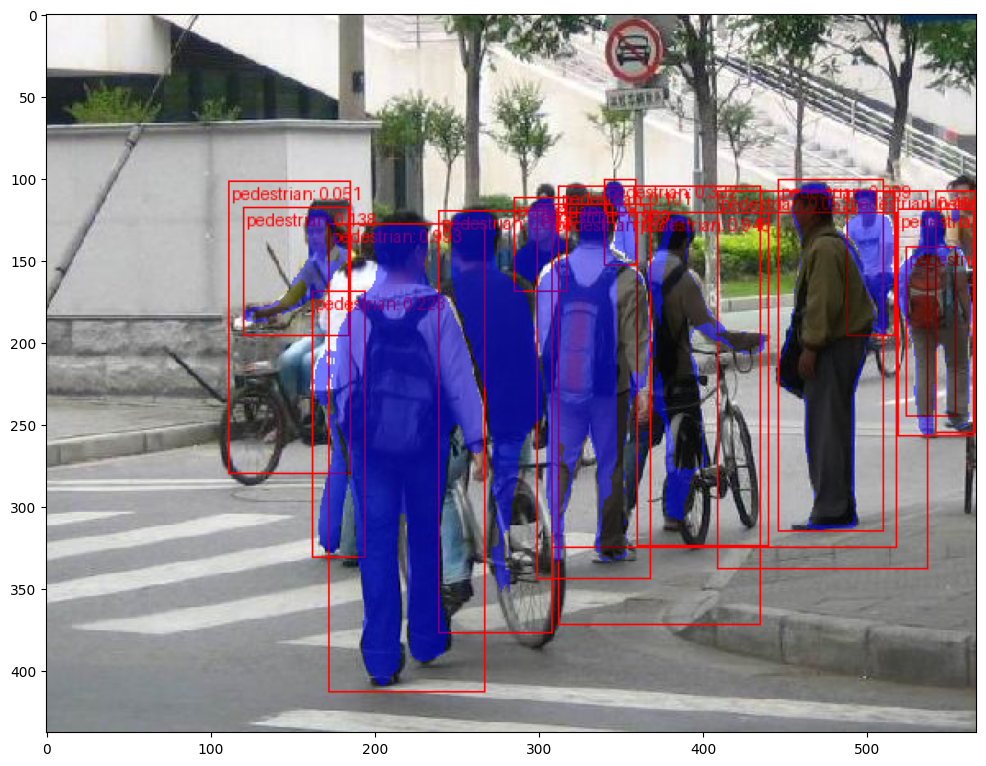

In [27]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks



image = read_image("datasets/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))